In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score




In [2]:
# Load the dataset
train_path = "train.csv"
test_path = "test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Pre Processing

In [3]:
train_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
# Fill missing values for numerical columns with median
num_cols = train_df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    train_df.loc[:, col] = train_df[col].fillna(train_df[col].median())
    if col in test_df.columns:
        test_df.loc[:, col] = test_df[col].fillna(test_df[col].median())

# Fill missing values for categorical columns with mode
cat_cols = train_df.select_dtypes(include=[object]).columns
for col in cat_cols:
    train_df.loc[:, col] = train_df[col].fillna(train_df[col].mode()[0])
    if col in test_df.columns:
        test_df.loc[:, col] = test_df[col].fillna(test_df[col].mode()[0])

In [6]:
# Encode categorical variables using Label Encoding (excluding 'Id')
encoder = LabelEncoder()

for col in cat_cols:
    if col != "Id":  # Ensure 'Id' is not encoded
        # Combine unique values from train and test for fitting the encoder
        combined_values = pd.concat([train_df[col], test_df[col]], axis=0).astype(str)
        encoder.fit(combined_values)  # Fit on combined unique values
        train_df.loc[:, col] = encoder.transform(train_df[col].astype(str))
        if col in test_df.columns:
            test_df.loc[:, col] = encoder.transform(test_df[col].astype(str))

# # Standardize numerical features (excluding 'Id' and 'SalePrice')
# scaler = StandardScaler()
# num_cols = [col for col in train_df.select_dtypes(include=[np.number]).columns if col not in ["Id", "SalePrice"]]

# train_df.loc[:, num_cols] = scaler.fit_transform(train_df[num_cols])
# test_df.loc[:, num_cols] = scaler.transform(test_df[num_cols])


In [7]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,0,3,3,0,...,0,2,2,2,0,2,2008,8,4,208500
1,2,20,3,80.0,9600,1,0,3,3,0,...,0,2,2,2,0,5,2007,8,4,181500
2,3,60,3,68.0,11250,1,0,0,3,0,...,0,2,2,2,0,9,2008,8,4,223500
3,4,70,3,60.0,9550,1,0,0,3,0,...,0,2,2,2,0,2,2006,8,0,140000
4,5,60,3,84.0,14260,1,0,0,3,0,...,0,2,2,2,0,12,2008,8,4,250000


# Feature Choice and Analysis

In [8]:
numeric_columns = train_df.select_dtypes(include=[np.number]).columns
correlation_matrix = train_df[numeric_columns].corr()
print(correlation_matrix["SalePrice"].sort_values(ascending=False))


SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
GarageYrBlt      0.466754
BsmtFinSF1       0.386420
LotFrontage      0.334771
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

In [9]:
# Identify columns with correlation less than 0.5
low_correlation_columns = correlation_matrix[correlation_matrix.abs() < 0.5].index.tolist()

# Ensure Id and SalePrice are not dropped
columns_to_keep = ["Id", "SalePrice"]
low_correlation_columns = [col for col in low_correlation_columns if col not in columns_to_keep]

# Drop these columns from both train_df and test_df
train_df = train_df.drop(columns=low_correlation_columns, errors="ignore")
test_df = test_df.drop(columns=low_correlation_columns, errors="ignore")

# Display remaining columns for verification
print("Remaining columns in train_df:")
print(train_df.columns)

print("\nRemaining columns in test_df:")
print(test_df.columns)

# Save the filtered datasets
train_df.to_csv("train_filtered.csv", index=False)
test_df.to_csv("test_filtered.csv", index=False)
print("\nFiltered datasets saved as 'train_filtered.csv' and 'test_filtered.csv'.")


Remaining columns in train_df:
Index(['Id', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'SalePrice'],
      dtype='object')

Remaining columns in test_df:
Index(['Id', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd'

In [10]:
train_df.head()

,Id,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice
0,1,3,1,0,3,3,0,4,0,5,...,1,4,4,2,2,2,2,8,4,208500
1,2,3,1,0,3,3,0,2,0,24,...,1,4,4,2,2,2,2,8,4,181500
2,3,3,1,0,0,3,0,4,0,5,...,1,4,4,2,2,2,2,8,4,223500
3,4,3,1,0,0,3,0,0,0,6,...,2,4,4,2,2,2,2,8,0,140000
4,5,3,1,0,0,3,0,2,0,15,...,1,4,4,2,2,2,2,8,4,250000


In [11]:
test_df.head()

,Id,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,1461,2,1,0,3,3,0,4,0,12,...,1,2,4,4,2,0,2,2,8,4
1,1462,3,1,0,0,3,0,0,0,12,...,1,2,4,4,2,0,2,0,8,4
2,1463,3,1,0,0,3,0,4,0,8,...,1,0,4,4,2,0,2,2,8,4
3,1464,3,1,0,0,3,0,4,0,8,...,1,0,4,4,2,0,2,2,8,4
4,1465,3,1,0,0,1,0,4,0,22,...,1,1,4,4,2,0,2,2,8,4


# Feature Engineering

In [12]:

train_df["ExteriorScore"] = train_df["ExterQual"] * train_df["ExterCond"]

# Basement quality score
train_df["BasementScore"] = train_df["BsmtQual"] * train_df["BsmtCond"]

# Has pool
train_df["HasPool"] = (train_df["PoolQC"] > 0).astype(int)

# Fence quality score
train_df["FenceScore"] = train_df["Fence"]

# Display the newly created features
print(train_df[["ExteriorScore", "BasementScore", "HasPool", "FenceScore"]].head())


  ExteriorScore BasementScore  HasPool FenceScore
0             8             6        1          2
1            12             6        1          2
2             8             6        1          2
3            12             3        1          2
4             8             6        1          2


In [13]:

test_df["ExteriorScore"] = test_df["ExterQual"] * test_df["ExterCond"]

# Basement quality score
test_df["BasementScore"] = test_df["BsmtQual"] * test_df["BsmtCond"]

# Has pool
test_df["HasPool"] = (test_df["PoolQC"] > 0).astype(int)

# Fence quality score
test_df["FenceScore"] = test_df["Fence"]

# Display the newly created features
print(test_df[["ExteriorScore", "BasementScore", "HasPool", "FenceScore"]].head())

  ExteriorScore BasementScore  HasPool FenceScore
0            12             9        0          2
1            12             9        0          2
2            12             6        0          2
3            12             9        0          2
4             8             6        0          2


In [14]:
sale_price_col = train_df.pop('SalePrice')
train_df['SalePrice'] = sale_price_col


In [15]:
train_df

,Id,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,ExteriorScore,BasementScore,HasPool,FenceScore,SalePrice
0,1,3,1,0,3,3,0,4,0,5,...,2,2,2,8,4,8,6,1,2,208500
1,2,3,1,0,3,3,0,2,0,24,...,2,2,2,8,4,12,6,1,2,181500
2,3,3,1,0,0,3,0,4,0,5,...,2,2,2,8,4,8,6,1,2,223500
3,4,3,1,0,0,3,0,0,0,6,...,2,2,2,8,0,12,3,1,2,140000
4,5,3,1,0,0,3,0,2,0,15,...,2,2,2,8,4,8,6,1,2,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,3,1,0,3,3,0,4,0,8,...,2,2,2,8,4,12,6,1,2,175000
1456,1457,3,1,0,3,3,0,4,0,14,...,2,2,2,8,4,12,6,1,2,210000
1457,1458,3,1,0,3,3,0,4,0,6,...,2,0,2,8,4,0,3,1,0,266500
1458,1459,3,1,0,3,3,0,4,0,12,...,2,2,2,8,4,12,9,1,2,142125


In [16]:
#save train_df to a csv
train_df.to_csv("train_filtered.csv", index=False)
test_df.to_csv("test_filtered.csv", index=False)

In [17]:
# Extract target variable
y = train_df['SalePrice'].values
X = train_df.drop(columns=['SalePrice', 'Id']).copy()

In [18]:
from sklearn.model_selection import train_test_split

# Include all columns except 'Id' and 'SalePrice'
X = train_df.drop(columns=['Id', 'SalePrice']).values
y = train_df['SalePrice'].values

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:


# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
test_X = scaler.transform(test_df.drop(columns=['Id'], errors='ignore'))

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
test_tensor = torch.tensor(test_X, dtype=torch.float32)



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [33]:


# Define a function to dynamically create models with different architectures
class ANNRegressor(nn.Module):
    def __init__(self, input_dim, hidden_layers):
        super(ANNRegressor, self).__init__()
        layers = []
        prev_dim = input_dim

        # Add hidden layers based on the architecture (list of layer sizes)
        for layer_dim in hidden_layers:
            layers.append(nn.Linear(prev_dim, layer_dim))  # Add a fully connected layer
            layers.append(nn.ReLU())  # ReLU activation function for non-linearity
            prev_dim = layer_dim

        # Add output layer (single output for regression)
        layers.append(nn.Linear(prev_dim, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Function to train and evaluate the model
def train_evaluate_model(architecture, lr, batch_size, num_epochs=200):
    # Initialize model with the specified architecture
    model = ANNRegressor(input_dim=X_train.shape[1], hidden_layers=architecture)

    # Define the loss function (Mean Squared Error for regression)
    criterion = nn.MSELoss()

    # Define the optimizer (Adam, can change learning rate)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Create DataLoader for training data with the specified batch size
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)  # Batch size

    # Initialize lists to track loss
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            y_pred = model(X_batch)  # Forward pass
            loss = criterion(y_pred, y_batch)  # Compute the loss
            loss.backward()  # Backward pass (compute gradients)
            optimizer.step()  # Update parameters

        # Track the training loss
        train_losses.append(loss.item())

        # Validation loss (evaluating model's performance on validation set)
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_tensor)
            val_loss = criterion(y_val_pred, y_val_tensor).item()
            val_losses.append(val_loss)

        # Print out the losses for each epoch
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss:.4f}")

    # Evaluate on the validation set and compute performance metrics
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        y_val_pred = model(X_val_tensor).numpy().flatten()  # Get model predictions
        y_val_true = y_val_tensor.numpy().flatten()  # True labels for validation data

    # Compute evaluation metrics (RMSE, MAE, R² score)
    mse = mean_squared_error(y_val_true, y_val_pred)
    mae = mean_absolute_error(y_val_true, y_val_pred)
    r2 = r2_score(y_val_true, y_val_pred)

    # Plot loss curves to visualize the training and validation losses over epochs
    plt.plot(range(num_epochs), train_losses, label=f'Train Loss ({architecture})')
    plt.plot(range(num_epochs), val_losses, label=f'Val Loss ({architecture})')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

    # Return the computed performance metrics
    return np.sqrt(mse), mae, r2




Training model with architecture [128, 64], learning rate 0.01, batch size 32
Epoch 1/200 | Train Loss: 45924339712.0000 | Val Loss: 38902145024.0000
Epoch 2/200 | Train Loss: 26374139904.0000 | Val Loss: 30287847424.0000
Epoch 3/200 | Train Loss: 9359562752.0000 | Val Loss: 11142678528.0000
Epoch 4/200 | Train Loss: 8012948992.0000 | Val Loss: 5245865472.0000
Epoch 5/200 | Train Loss: 3407253760.0000 | Val Loss: 3732457472.0000
Epoch 6/200 | Train Loss: 2095712384.0000 | Val Loss: 3503351040.0000
Epoch 7/200 | Train Loss: 5620225536.0000 | Val Loss: 3351456512.0000
Epoch 8/200 | Train Loss: 2163568384.0000 | Val Loss: 3179958272.0000
Epoch 9/200 | Train Loss: 2362417664.0000 | Val Loss: 3096695296.0000
Epoch 10/200 | Train Loss: 13678505984.0000 | Val Loss: 3027287040.0000
Epoch 11/200 | Train Loss: 2946666240.0000 | Val Loss: 2947507456.0000
Epoch 12/200 | Train Loss: 2981188864.0000 | Val Loss: 2919562496.0000
Epoch 13/200 | Train Loss: 3874955264.0000 | Val Loss: 2881169920.0000
Ep

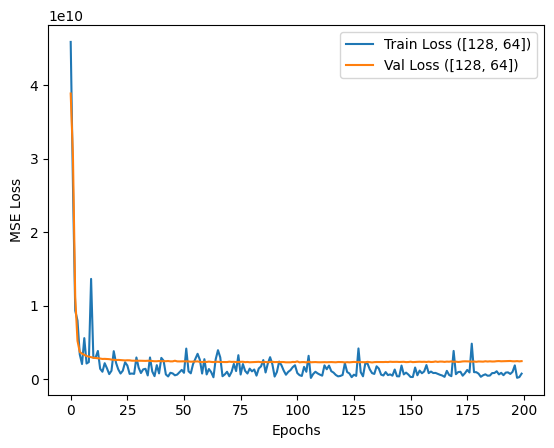

Training model with architecture [128, 64], learning rate 0.01, batch size 64
Epoch 1/200 | Train Loss: 34790088704.0000 | Val Loss: 39591473152.0000
Epoch 2/200 | Train Loss: 50736214016.0000 | Val Loss: 38971449344.0000
Epoch 3/200 | Train Loss: 30070118400.0000 | Val Loss: 36523749376.0000
Epoch 4/200 | Train Loss: 27690334208.0000 | Val Loss: 30577444864.0000
Epoch 5/200 | Train Loss: 20377245696.0000 | Val Loss: 20948779008.0000
Epoch 6/200 | Train Loss: 14753828864.0000 | Val Loss: 10918836224.0000
Epoch 7/200 | Train Loss: 5548898816.0000 | Val Loss: 5879598080.0000
Epoch 8/200 | Train Loss: 5690041344.0000 | Val Loss: 4438669312.0000
Epoch 9/200 | Train Loss: 6102955008.0000 | Val Loss: 3920863232.0000
Epoch 10/200 | Train Loss: 5338152960.0000 | Val Loss: 3759118848.0000
Epoch 11/200 | Train Loss: 6637526528.0000 | Val Loss: 3654913024.0000
Epoch 12/200 | Train Loss: 4434194944.0000 | Val Loss: 3545770240.0000
Epoch 13/200 | Train Loss: 2974169088.0000 | Val Loss: 3429616128.0

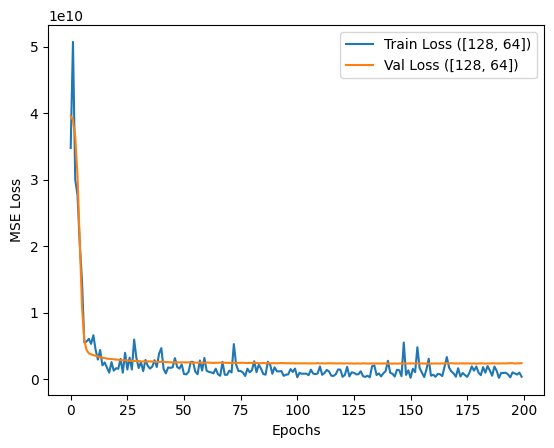

Training model with architecture [128, 64], learning rate 0.001, batch size 32
Epoch 1/200 | Train Loss: 40715112448.0000 | Val Loss: 39652282368.0000
Epoch 2/200 | Train Loss: 49551245312.0000 | Val Loss: 39643594752.0000
Epoch 3/200 | Train Loss: 47154089984.0000 | Val Loss: 39613669376.0000
Epoch 4/200 | Train Loss: 47251062784.0000 | Val Loss: 39541129216.0000
Epoch 5/200 | Train Loss: 33438486528.0000 | Val Loss: 39398596608.0000
Epoch 6/200 | Train Loss: 28875511808.0000 | Val Loss: 39167057920.0000
Epoch 7/200 | Train Loss: 31845429248.0000 | Val Loss: 38819667968.0000
Epoch 8/200 | Train Loss: 23703201792.0000 | Val Loss: 38320771072.0000
Epoch 9/200 | Train Loss: 35619373056.0000 | Val Loss: 37671419904.0000
Epoch 10/200 | Train Loss: 27080699904.0000 | Val Loss: 36850077696.0000
Epoch 11/200 | Train Loss: 72869289984.0000 | Val Loss: 35852869632.0000
Epoch 12/200 | Train Loss: 28557801472.0000 | Val Loss: 34677825536.0000
Epoch 13/200 | Train Loss: 27752054784.0000 | Val Loss

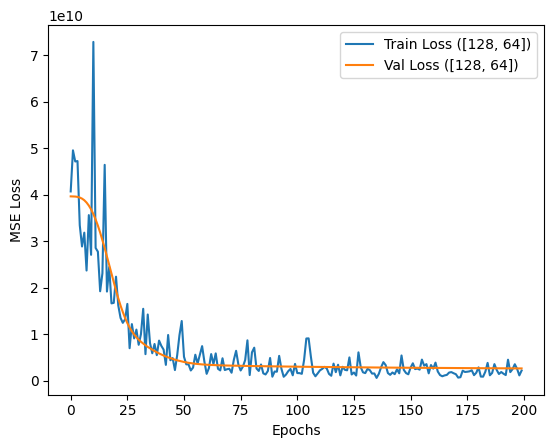

Training model with architecture [128, 64], learning rate 0.001, batch size 64
Epoch 1/200 | Train Loss: 53121142784.0000 | Val Loss: 39653343232.0000
Epoch 2/200 | Train Loss: 62712020992.0000 | Val Loss: 39651708928.0000
Epoch 3/200 | Train Loss: 37148426240.0000 | Val Loss: 39647780864.0000
Epoch 4/200 | Train Loss: 49783615488.0000 | Val Loss: 39639441408.0000
Epoch 5/200 | Train Loss: 50954493952.0000 | Val Loss: 39623639040.0000
Epoch 6/200 | Train Loss: 29644560384.0000 | Val Loss: 39597002752.0000
Epoch 7/200 | Train Loss: 41174740992.0000 | Val Loss: 39555387392.0000
Epoch 8/200 | Train Loss: 30532227072.0000 | Val Loss: 39493529600.0000
Epoch 9/200 | Train Loss: 37258776576.0000 | Val Loss: 39410343936.0000
Epoch 10/200 | Train Loss: 32230778880.0000 | Val Loss: 39299018752.0000
Epoch 11/200 | Train Loss: 38571933696.0000 | Val Loss: 39158280192.0000
Epoch 12/200 | Train Loss: 63723266048.0000 | Val Loss: 38984720384.0000
Epoch 13/200 | Train Loss: 47782633472.0000 | Val Loss

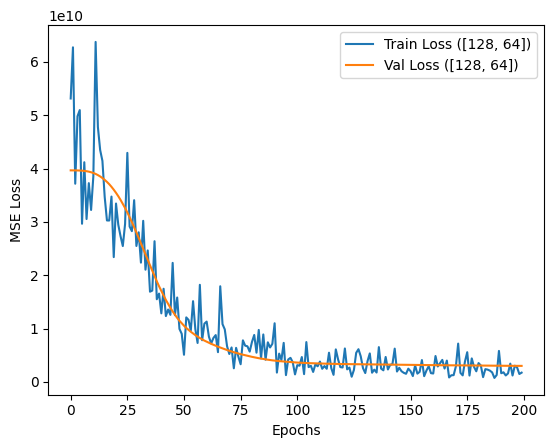

Training model with architecture [128, 64, 32], learning rate 0.01, batch size 32
Epoch 1/200 | Train Loss: 33883267072.0000 | Val Loss: 34380730368.0000
Epoch 2/200 | Train Loss: 2872849152.0000 | Val Loss: 4172435968.0000
Epoch 3/200 | Train Loss: 5142699520.0000 | Val Loss: 3365853696.0000
Epoch 4/200 | Train Loss: 2637808896.0000 | Val Loss: 3128956416.0000
Epoch 5/200 | Train Loss: 2602313984.0000 | Val Loss: 2903131392.0000
Epoch 6/200 | Train Loss: 2315475968.0000 | Val Loss: 2777560320.0000
Epoch 7/200 | Train Loss: 3499904256.0000 | Val Loss: 2820537856.0000
Epoch 8/200 | Train Loss: 2624798976.0000 | Val Loss: 2756329984.0000
Epoch 9/200 | Train Loss: 1622447232.0000 | Val Loss: 2660878080.0000
Epoch 10/200 | Train Loss: 1964592128.0000 | Val Loss: 2881624832.0000
Epoch 11/200 | Train Loss: 2943531008.0000 | Val Loss: 2601686016.0000
Epoch 12/200 | Train Loss: 2914841856.0000 | Val Loss: 2671394304.0000
Epoch 13/200 | Train Loss: 1230261760.0000 | Val Loss: 2720001536.0000
Ep

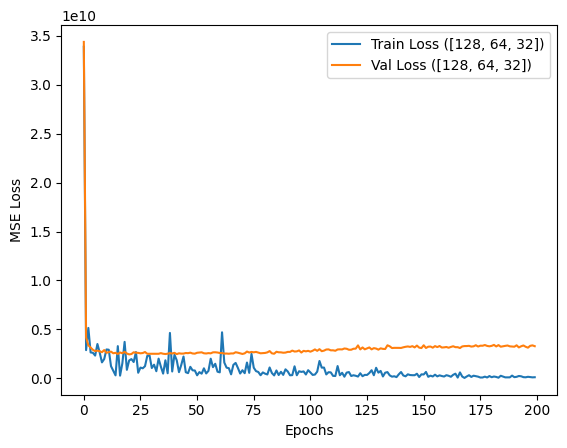

Training model with architecture [128, 64, 32], learning rate 0.01, batch size 64
Epoch 1/200 | Train Loss: 43824427008.0000 | Val Loss: 39379836928.0000
Epoch 2/200 | Train Loss: 37741719552.0000 | Val Loss: 33469040640.0000
Epoch 3/200 | Train Loss: 9684603904.0000 | Val Loss: 9316910080.0000
Epoch 4/200 | Train Loss: 2704969728.0000 | Val Loss: 4116600320.0000
Epoch 5/200 | Train Loss: 4108644352.0000 | Val Loss: 3476283392.0000
Epoch 6/200 | Train Loss: 1952460672.0000 | Val Loss: 3128276992.0000
Epoch 7/200 | Train Loss: 2034112000.0000 | Val Loss: 2893482752.0000
Epoch 8/200 | Train Loss: 1799124096.0000 | Val Loss: 2841444864.0000
Epoch 9/200 | Train Loss: 3298736640.0000 | Val Loss: 2830928640.0000
Epoch 10/200 | Train Loss: 5374942208.0000 | Val Loss: 2808522240.0000
Epoch 11/200 | Train Loss: 2325812992.0000 | Val Loss: 2784137216.0000
Epoch 12/200 | Train Loss: 1272423680.0000 | Val Loss: 2754206464.0000
Epoch 13/200 | Train Loss: 1770027264.0000 | Val Loss: 2748336896.0000


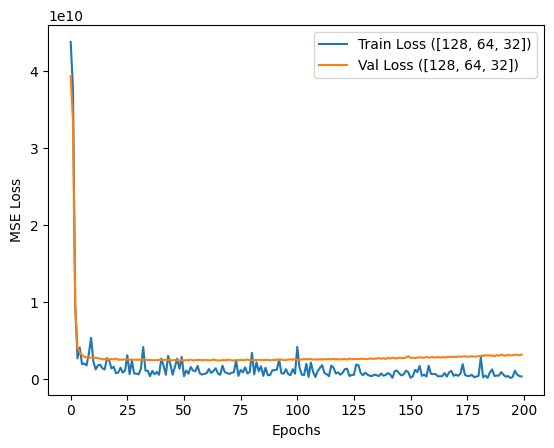

Training model with architecture [128, 64, 32], learning rate 0.001, batch size 32
Epoch 1/200 | Train Loss: 27588534272.0000 | Val Loss: 39651516416.0000
Epoch 2/200 | Train Loss: 37036326912.0000 | Val Loss: 39617961984.0000
Epoch 3/200 | Train Loss: 22570598400.0000 | Val Loss: 39411445760.0000
Epoch 4/200 | Train Loss: 59345309696.0000 | Val Loss: 38654935040.0000
Epoch 5/200 | Train Loss: 32348463104.0000 | Val Loss: 36654972928.0000
Epoch 6/200 | Train Loss: 31258769408.0000 | Val Loss: 32657702912.0000
Epoch 7/200 | Train Loss: 18399160320.0000 | Val Loss: 26377078784.0000
Epoch 8/200 | Train Loss: 15604513792.0000 | Val Loss: 18736746496.0000
Epoch 9/200 | Train Loss: 15281613824.0000 | Val Loss: 12639953920.0000
Epoch 10/200 | Train Loss: 7912100352.0000 | Val Loss: 9437415424.0000
Epoch 11/200 | Train Loss: 7389201920.0000 | Val Loss: 7888439296.0000
Epoch 12/200 | Train Loss: 5696785408.0000 | Val Loss: 6734093312.0000
Epoch 13/200 | Train Loss: 11597220864.0000 | Val Loss: 

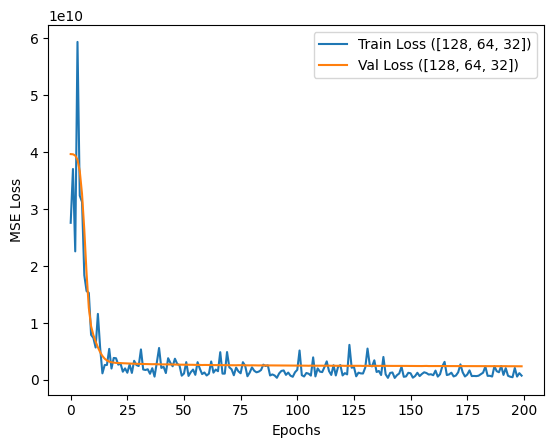

Training model with architecture [128, 64, 32], learning rate 0.001, batch size 64
Epoch 1/200 | Train Loss: 23052623872.0000 | Val Loss: 39653429248.0000
Epoch 2/200 | Train Loss: 56463880192.0000 | Val Loss: 39650635776.0000
Epoch 3/200 | Train Loss: 43304501248.0000 | Val Loss: 39639109632.0000
Epoch 4/200 | Train Loss: 37052268544.0000 | Val Loss: 39602446336.0000
Epoch 5/200 | Train Loss: 32626706432.0000 | Val Loss: 39508918272.0000
Epoch 6/200 | Train Loss: 51811962880.0000 | Val Loss: 39299186688.0000
Epoch 7/200 | Train Loss: 32216092672.0000 | Val Loss: 38889336832.0000
Epoch 8/200 | Train Loss: 43509088256.0000 | Val Loss: 38165209088.0000
Epoch 9/200 | Train Loss: 45189357568.0000 | Val Loss: 36996923392.0000
Epoch 10/200 | Train Loss: 59727257600.0000 | Val Loss: 35209863168.0000
Epoch 11/200 | Train Loss: 35303481344.0000 | Val Loss: 32697483264.0000
Epoch 12/200 | Train Loss: 22682810368.0000 | Val Loss: 29525825536.0000
Epoch 13/200 | Train Loss: 25196259328.0000 | Val 

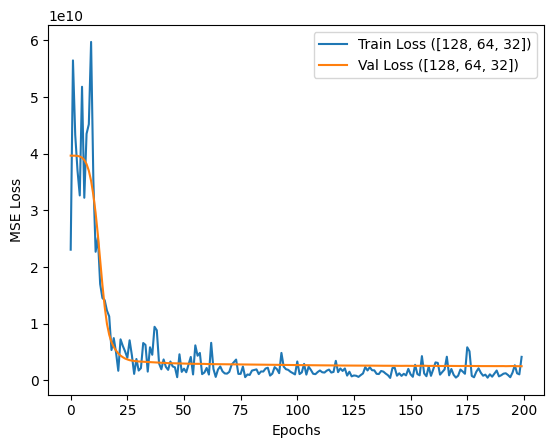

Training model with architecture [256, 128, 64, 32], learning rate 0.01, batch size 32
Epoch 1/200 | Train Loss: 20019859456.0000 | Val Loss: 7389508608.0000
Epoch 2/200 | Train Loss: 4010659840.0000 | Val Loss: 3096548096.0000
Epoch 3/200 | Train Loss: 2520994816.0000 | Val Loss: 2867751424.0000
Epoch 4/200 | Train Loss: 1676117504.0000 | Val Loss: 2678397184.0000
Epoch 5/200 | Train Loss: 896682816.0000 | Val Loss: 2622750464.0000
Epoch 6/200 | Train Loss: 3365546496.0000 | Val Loss: 2687524608.0000
Epoch 7/200 | Train Loss: 2042321280.0000 | Val Loss: 2501000960.0000
Epoch 8/200 | Train Loss: 794284352.0000 | Val Loss: 2604585472.0000
Epoch 9/200 | Train Loss: 3722689024.0000 | Val Loss: 2510813184.0000
Epoch 10/200 | Train Loss: 2131922048.0000 | Val Loss: 2419480832.0000
Epoch 11/200 | Train Loss: 540708096.0000 | Val Loss: 2364738560.0000
Epoch 12/200 | Train Loss: 388412608.0000 | Val Loss: 2537953536.0000
Epoch 13/200 | Train Loss: 1465802368.0000 | Val Loss: 2696324864.0000
Ep

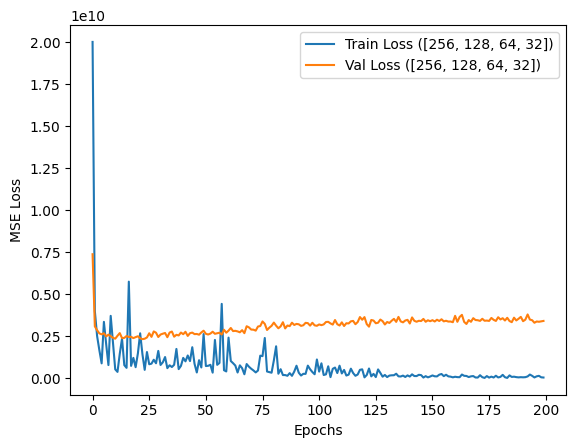

Training model with architecture [256, 128, 64, 32], learning rate 0.01, batch size 64
Epoch 1/200 | Train Loss: 53137793024.0000 | Val Loss: 35734155264.0000
Epoch 2/200 | Train Loss: 2241082880.0000 | Val Loss: 5141727744.0000
Epoch 3/200 | Train Loss: 4046978304.0000 | Val Loss: 3764552192.0000
Epoch 4/200 | Train Loss: 4255649024.0000 | Val Loss: 2814587136.0000
Epoch 5/200 | Train Loss: 1241514368.0000 | Val Loss: 2844481024.0000
Epoch 6/200 | Train Loss: 2887339776.0000 | Val Loss: 2701864448.0000
Epoch 7/200 | Train Loss: 3589225216.0000 | Val Loss: 2763739136.0000
Epoch 8/200 | Train Loss: 569559360.0000 | Val Loss: 2633488640.0000
Epoch 9/200 | Train Loss: 3032974848.0000 | Val Loss: 2805666816.0000
Epoch 10/200 | Train Loss: 1948353792.0000 | Val Loss: 2657045760.0000
Epoch 11/200 | Train Loss: 5607944704.0000 | Val Loss: 2519406848.0000
Epoch 12/200 | Train Loss: 5400907264.0000 | Val Loss: 2688224000.0000
Epoch 13/200 | Train Loss: 2643013376.0000 | Val Loss: 2612065536.000

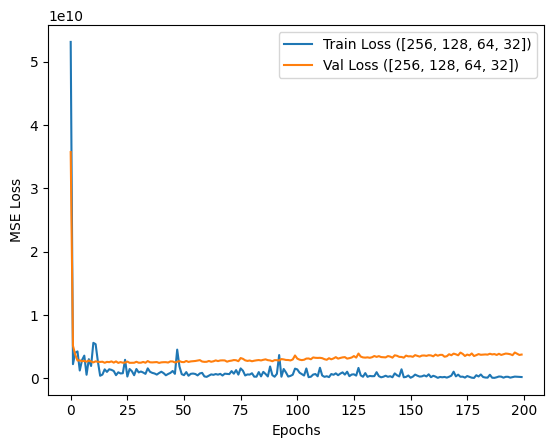

Training model with architecture [256, 128, 64, 32], learning rate 0.001, batch size 32
Epoch 1/200 | Train Loss: 31826118656.0000 | Val Loss: 39643033600.0000
Epoch 2/200 | Train Loss: 30310959104.0000 | Val Loss: 39261261824.0000
Epoch 3/200 | Train Loss: 42300686336.0000 | Val Loss: 35172192256.0000
Epoch 4/200 | Train Loss: 17655324672.0000 | Val Loss: 18390388736.0000
Epoch 5/200 | Train Loss: 4804639232.0000 | Val Loss: 6780006912.0000
Epoch 6/200 | Train Loss: 2122231168.0000 | Val Loss: 4217333248.0000
Epoch 7/200 | Train Loss: 3756598784.0000 | Val Loss: 3115399680.0000
Epoch 8/200 | Train Loss: 1632164736.0000 | Val Loss: 2909792768.0000
Epoch 9/200 | Train Loss: 2237048832.0000 | Val Loss: 2904671744.0000
Epoch 10/200 | Train Loss: 4143271680.0000 | Val Loss: 2832670976.0000
Epoch 11/200 | Train Loss: 2666487040.0000 | Val Loss: 2812758528.0000
Epoch 12/200 | Train Loss: 3439627264.0000 | Val Loss: 2762916608.0000
Epoch 13/200 | Train Loss: 1455004800.0000 | Val Loss: 274295

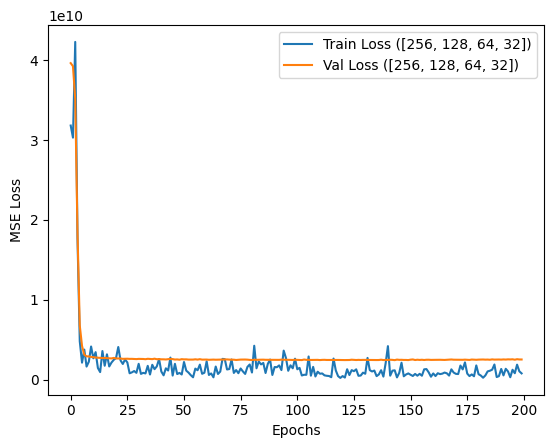

Training model with architecture [256, 128, 64, 32], learning rate 0.001, batch size 64
Epoch 1/200 | Train Loss: 60258107392.0000 | Val Loss: 39653367808.0000
Epoch 2/200 | Train Loss: 32979046400.0000 | Val Loss: 39645331456.0000
Epoch 3/200 | Train Loss: 48732499968.0000 | Val Loss: 39583719424.0000
Epoch 4/200 | Train Loss: 48433864704.0000 | Val Loss: 39261921280.0000
Epoch 5/200 | Train Loss: 43291820032.0000 | Val Loss: 38047698944.0000
Epoch 6/200 | Train Loss: 25264115712.0000 | Val Loss: 34512805888.0000
Epoch 7/200 | Train Loss: 23137734656.0000 | Val Loss: 26645114880.0000
Epoch 8/200 | Train Loss: 17960882176.0000 | Val Loss: 14662108160.0000
Epoch 9/200 | Train Loss: 5825895424.0000 | Val Loss: 6523366400.0000
Epoch 10/200 | Train Loss: 9958620160.0000 | Val Loss: 4633755136.0000
Epoch 11/200 | Train Loss: 3111134464.0000 | Val Loss: 3682533376.0000
Epoch 12/200 | Train Loss: 1918666880.0000 | Val Loss: 3223862272.0000
Epoch 13/200 | Train Loss: 3061490176.0000 | Val Loss

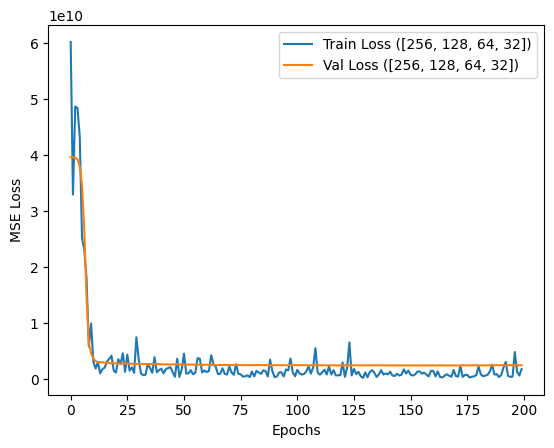

,Architecture,Learning Rate,Batch Size,RMSE,MAE,R² Score
0,"[128, 64]",0.010,32,49898.418412,34748.062500,0.675392
1,"[128, 64]",0.010,64,49397.496293,34073.246094,0.681876
2,"[128, 64]",0.001,32,51441.333731,36317.328125,0.655007
3,"[128, 64]",0.001,64,54855.516404,40131.335938,0.607692
4,"[128, 64, 32]",0.010,32,57237.123617,39431.582031,0.572888
5,"[128, 64, 32]",0.010,64,56527.322951,39693.425781,0.583416
6,"[128, 64, 32]",0.001,32,48936.417850,33430.093750,0.687787
7,"[128, 64, 32]",0.001,64,49789.771158,34181.429688,0.676804
8,"[256, 128, 64, 32]",0.010,32,58482.624291,40702.617188,0.554098
9,"[256, 128, 64, 32]",0.010,64,61301.807086,43114.507812,0.510071


In [34]:
# Define hyperparameters to experiment with (reduced search space)
architectures = [
    [128, 64],            # Two hidden layers: 128 units and 64 units
    [128, 64, 32],        # Three hidden layers: 128, 64, and 32 units
    [256,128, 64, 32]
]

learning_rates = [0.01, 0.001]  # Learning rate settings
batch_sizes = [32, 64]  # Batch sizes

# Record and discuss the results of each combination of hyperparameters
results = []
for arch in architectures:  # Iterate over different architectures
    for lr in learning_rates:  # Iterate over different learning rates
        for batch_size in batch_sizes:  # Iterate over different batch sizes
            print(f"Training model with architecture {arch}, learning rate {lr}, batch size {batch_size}")
            # Train and evaluate the model with the current combination of hyperparameters
            rmse, mae, r2 = train_evaluate_model(arch, lr, batch_size)
            # Store the results
            results.append({
                'Architecture': arch,        # Current architecture
                'Learning Rate': lr,         # Current learning rate
                'Batch Size': batch_size,    # Current batch size
                'RMSE': rmse,                # RMSE (Root Mean Squared Error)
                'MAE': mae,                  # MAE (Mean Absolute Error)
                'R² Score': r2               # R² Score (coefficient of determination)
            })

# Display the results in a DataFrame
import pandas as pd
results_df = pd.DataFrame(results)

# Displaying the DataFrame directly in the notebook
results_df
